In [1]:
import specdist as pi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interp1d
from matplotlib.pyplot import cm
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.collections import LineCollection
from matplotlib.ticker import LogLocator
import re
scientific_notation = pi.scientific_notation

import warnings; warnings.simplefilter('ignore')

path_to_figures = "/Users/boris/Work/SPECTRAL-DISTORTIONS/figures/"

xinj_to_mass = 4.698e-4 #m in ev = 4.698e-4 xinj
#1./4.698e-4*2. = 4257.130693912303

# sd_lib_bare = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('bare',sd_lib_bare)


# sd_lib_lyc = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('lyc',sd_lib_lyc)

# sd_lib_lyc_reio = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('lyc_reio',sd_lib_lyc_reio)




label_y_firas = r'$y_\mathrm{COBE}=1.5\times 10^{-5}$'
label_mu_firas = r'$\mu_\mathrm{COBE}=9\times 10^{-5}$'
label_fdm = 'Effective Dark Matter Fraction, '+r'$\epsilon f_\mathrm{dm}$'
label_mdm = 'Particle Mass, ' +r'$m_\mathrm{dm}\,\,[\mathrm{eV}]$'
label_xe = 'Free Electron Fraction, '+r'$X_\mathrm{e}$'
label_redshift = 'Redshift, '+r'$z$'
label_mu_dist =  'Chemical Potential, '+r'$\mu$'
label_injection_frequency = "Scaled Injection Frequency, "+ r'$x_{\mathrm{inj,0}}$'
label_scaled_frequency = "Scaled Frequency, "+ r'$x=h\nu/k_{_\mathrm{B}}T_{_\mathrm{CMB}}$'
label_frequency_in_GHz = "Frequency,  "+ r'$\nu \quad [\mathrm{GHz}]$'
label_intensity = "Intensity, "+r'$\Delta I_x \quad [\mathrm{Jy/sr}]$'
label_intensity_kJy = "Intensity, "+r'$\Delta I_x \quad [\mathrm{kJy/sr}]$'
label_injection_energy = "Injection Energy, "+ r'$E_{\mathrm{inj,0}}$' + " [eV]"
xinj_to_Einj = 4.698e-4/2.
label_Gamma = "Decay Rate, "+r"$\Gamma_X\quad[\mathrm{s^{-1}}]$"

label_zX = "Maximum Injection Redshift, "+ r'$z_X$'
sd = pi

In [2]:
sd_lib_xe_history = pi.specdist_ct_spectra_lib()
pi.load_ct_spectra_lib('xe_history_180720',sd_lib_xe_history)
sd_lib_lyc_reio = pi.specdist_ct_spectra_lib()
pi.load_ct_spectra_lib('lyc_reio',sd_lib_lyc_reio)

In [26]:
def find_nearests(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if array[idx]>value:
        idxp =idx
        idxm = idx-1
    else:
        idxm = idx
        idxp = idx+1
    if idxp == len(array):
        idxm -= 1
        idxp -= 1
    return (idxm,idxp)

def GetSpectra(Gamma_inj_asked,x_inj_asked,x_asked,specdist_ct_spectra_lib):
    r1 = (Gamma_inj_asked - specdist_ct_spectra_lib.Gamma_inj_min)
    r2 = (specdist_ct_spectra_lib.Gamma_inj_max - Gamma_inj_asked)
    r3 = (x_inj_asked - specdist_ct_spectra_lib.x_inj_min)
    r4 = (specdist_ct_spectra_lib.x_inj_max - x_inj_asked)

    if (r1 < 0) or (r2 < 0) or (r3 < 0) or (r4 < 0):
        print('filling with nans')
        array_x_asked =  np.empty(len(x_asked))
        array_x_asked[:] = np.nan
        array_S_result = np.empty(len(x_asked))
        array_S_result[:] =  np.nan
        F_gamma_asked_xinj_asked = np.nan

    else:
        X_2d =  specdist_ct_spectra_lib.X_2d
        DI_2d = specdist_ct_spectra_lib.DI_2d
        finj_2d = specdist_ct_spectra_lib.finj_2d

        Gamma_values = specdist_ct_spectra_lib.Gamma_values
        x_inj_values =  specdist_ct_spectra_lib.x_inj_values
        # print(Gamma_values)
        # print(x_inj_values)
        # print(find_nearests(Gamma_values, Gamma_inj_asked))
        id_gamma_low = find_nearests(Gamma_values, Gamma_inj_asked)[0]
        id_gamma_high = find_nearests(Gamma_values, Gamma_inj_asked)[1]

        id_xinj_low = find_nearests(x_inj_values, x_inj_asked)[0]
        id_xinj_high = find_nearests(x_inj_values, x_inj_asked)[1]
        
        #print(id_gamma_low,id_gamma_high,id_xinj_low,id_xinj_high)

        #DI_2d[id_gamma_low][id_xinj_low]  #DI_2d[id_gamma_low][id_xinj_high]
        #X_2d[id_gamma_low][id_xinj_low]   #X_2d[id_gamma_low][id_xinj_high]

        #DI_2d[id_gamma_high][id_xinj_low]  #DI_2d[id_gamma_high][id_xinj_high]
        #X_2d[id_gamma_high][id_xinj_low]   #X_2d[id_gamma_high][id_xinj_high]
        S = [[X_2d[id_gamma_low][id_xinj_low],DI_2d[id_gamma_low][id_xinj_low]],[X_2d[id_gamma_low][id_xinj_high],DI_2d[id_gamma_low][id_xinj_high]],[X_2d[id_gamma_high][id_xinj_low],DI_2d[id_gamma_high][id_xinj_low]],[X_2d[id_gamma_high][id_xinj_high],DI_2d[id_gamma_high][id_xinj_high]]]
        F = [finj_2d[id_gamma_low][id_xinj_low],finj_2d[id_gamma_low][id_xinj_high],finj_2d[id_gamma_high][id_xinj_low],finj_2d[id_gamma_high][id_xinj_high]]
        dict = {
        "gamma_low": Gamma_values[id_gamma_low],
        "gamma_high": Gamma_values[id_gamma_high],
        "xinj_low": x_inj_values[id_xinj_low],
        "xinj_high": x_inj_values[id_xinj_high],
        "spectra": S,
        "finj": F
        }
        
        #print(F)

        gamma_low = dict["gamma_low"]
        gamma_high = dict["gamma_high"]
        xinj_low = dict["xinj_low"]
        xinj_high = dict["xinj_high"]
        S = dict["spectra"]
        F = dict["finj"]

        S_gamma_low_xinj_low = S[0]
        S_gamma_low_xinj_high = S[1]
        S_gamma_high_xinj_low = S[2]
        S_gamma_high_xinj_high = S[3]

        F_gamma_low_xinj_low = F[0][0]
        F_gamma_low_xinj_high = F[1][0]
        F_gamma_high_xinj_low = F[2][0]
        F_gamma_high_xinj_high = F[3][0]

        Gamma_asked = Gamma_inj_asked
        xinj_asked = x_inj_asked

        #check if nan in any of the arrays:
        Arrays_list = [S_gamma_low_xinj_low,
                      S_gamma_low_xinj_high,
                      S_gamma_high_xinj_low,
                      S_gamma_high_xinj_high]
        has_nan = False
        for p in Arrays_list:
            array = p
            array_sum = np.sum(array)
            has_nan += np.isnan(array_sum)
        if has_nan:
            print('filling with nans')
            array_x_asked =  np.empty(len(x_asked))
            array_x_asked[:] = np.nan
            array_S_result = np.empty(len(x_asked))
            array_S_result[:] =  np.nan
            F_gamma_asked_xinj_asked = np.nan
        else:
            nx = int(1e4)


            ############### xinj_low
            new_x_min = np.maximum(np.min(S_gamma_low_xinj_low[0]),np.min(S_gamma_high_xinj_low[0]))
            new_x_max = np.minimum(np.max(S_gamma_low_xinj_low[0]),np.max(S_gamma_high_xinj_low[0]))
            new_x_array = np.logspace(np.log10(new_x_min),np.log10(new_x_max),nx)
            new_x_array = new_x_array[1:-1]


            f_gamma_low = interp1d(S_gamma_low_xinj_low[0], S_gamma_low_xinj_low[1])
            f_gamma_high = interp1d(S_gamma_high_xinj_low[0], S_gamma_high_xinj_low[1])

            new_S_gamma_low = f_gamma_low(new_x_array)
            new_S_gamma_high = f_gamma_high(new_x_array)

            #w = (gamma_high - Gamma_asked)/(gamma_high - gamma_low)
            w = (np.log(gamma_high) - np.log(Gamma_asked))/(np.log(gamma_high) - np.log(gamma_low))
            new_S_gamma_asked = w*new_S_gamma_low + (1.-w)*new_S_gamma_high



            S_gamma_asked_xinj_low = [[],[]]
            S_gamma_asked_xinj_low[0] = new_x_array
            S_gamma_asked_xinj_low[1] = new_S_gamma_asked

            F_gamma_asked_xinj_low = w*F_gamma_low_xinj_low + (1.-w)*F_gamma_high_xinj_low

            ############# xinj_high

            new_x_min = np.maximum(np.min(S_gamma_low_xinj_high[0]),np.min(S_gamma_high_xinj_high[0]))
            new_x_max = np.minimum(np.max(S_gamma_low_xinj_high[0]),np.max(S_gamma_high_xinj_high[0]))
            new_x_array = np.logspace(np.log10(new_x_min),np.log10(new_x_max),nx)
            new_x_array = new_x_array[1:-1]

            f_gamma_low = interp1d(S_gamma_low_xinj_high[0], S_gamma_low_xinj_high[1])
            f_gamma_high = interp1d(S_gamma_high_xinj_high[0], S_gamma_high_xinj_high[1])

            new_S_gamma_low = f_gamma_low(new_x_array)
            new_S_gamma_high = f_gamma_high(new_x_array)

            #w = (gamma_high - Gamma_asked)/(gamma_high - gamma_low)
            w = (np.log(gamma_high) - np.log(Gamma_asked))/(np.log(gamma_high) - np.log(gamma_low))
            new_S_gamma_asked = w*new_S_gamma_low + (1.-w)*new_S_gamma_high

            S_gamma_asked_xinj_high = [[],[]]
            S_gamma_asked_xinj_high[0] = new_x_array
            S_gamma_asked_xinj_high[1] = new_S_gamma_asked

            F_gamma_asked_xinj_high = w*F_gamma_low_xinj_low + (1.-w)*F_gamma_high_xinj_high

            ############# interpolation between xinjs
            new_x_min = np.maximum(np.min(S_gamma_asked_xinj_low[0]),np.min(S_gamma_asked_xinj_high[0]))
            new_x_max = np.minimum(np.max(S_gamma_asked_xinj_low[0]),np.max(S_gamma_asked_xinj_high[0]))
            new_x_array = np.logspace(np.log10(new_x_min),np.log10(new_x_max),nx)
            new_x_array = new_x_array[1:-1]

            f_xinj_low = interp1d(S_gamma_asked_xinj_low[0], S_gamma_asked_xinj_low[1])
            f_xinj_high = interp1d(S_gamma_asked_xinj_high[0], S_gamma_asked_xinj_high[1])

            new_S_xinj_low = f_xinj_low(new_x_array)
            new_S_xinj_high = f_xinj_high(new_x_array)

            #w = (xinj_high - xinj_asked)/(xinj_high - xinj_low)
            w = (np.log(xinj_high) - np.log(xinj_asked))/(np.log(xinj_high) - np.log(xinj_low))
            new_S_xinj_asked = w*new_S_xinj_low + (1.-w)*new_S_xinj_high

            S_gamma_asked_xinj_asked = [[],[]]
            S_gamma_asked_xinj_asked[0] = new_x_array
            S_gamma_asked_xinj_asked[1] = new_S_xinj_asked

            F_gamma_asked_xinj_asked = w*F_gamma_asked_xinj_low + (1.-w)*F_gamma_asked_xinj_high


            f_gamma_asked_xinj_asked = interp1d(S_gamma_asked_xinj_asked[0], S_gamma_asked_xinj_asked[1])
            ########### get spectra at required x values
            bound_x_min = np.min(S_gamma_asked_xinj_asked[0])
            bound_x_max = np.max(S_gamma_asked_xinj_asked[0])

            array_x_asked = np.asarray(x_asked)

            min_x_asked = np.min(array_x_asked)
            max_x_asked = np.max(array_x_asked)

            id_min = 0
            id_max = None
            if min_x_asked < bound_x_min:
                id_min = find_nearests(array_x_asked, bound_x_min)[1]
            if max_x_asked > bound_x_max:
                id_max = find_nearests(array_x_asked, bound_x_max)[0]
            array_x_asked = array_x_asked[id_min:id_max]

            array_S_result = f_gamma_asked_xinj_asked(array_x_asked)

    r_dict = {"x":array_x_asked,
              "DI": array_S_result,
              "finj": F_gamma_asked_xinj_asked}

    return r_dict



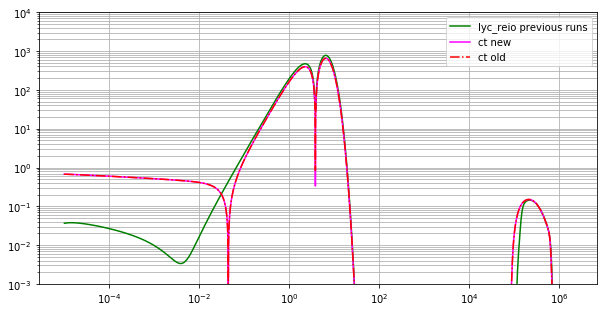

In [40]:
i=32

x_asked = np.logspace(np.log10(1e-10),np.log10(1e10),1000)
gamma_asked = 1.e-17
xinj_asked = 6.49451e5
# new runs 6.449e+05
#xinj_old_run i = 189 #249451
# S_bare = pi.GetSpectra(gamma_asked,xinj_asked,x_asked,sd_lib_bare)
# S_mu_fit = pi.GetSpectra(gamma_asked,xinj_asked,x_asked,sd_lib_mu_fit)
S_lyc_reio = pi.GetSpectra(gamma_asked,xinj_asked,x_asked,sd_lib_lyc_reio)
#S_xe_history = pi.GetSpectra(gamma_asked,xinj_asked,x_asked,sd_lib_xe_history)

fig, (ax) = plt.subplots(1,1,figsize=(10,5))
# S = S_bare
# plt.plot(S['x'],np.abs(S['DI']),c='k',label='bare')
# S = S_mu_fit
# plt.plot(S['x'],np.abs(S['DI']),c='r',label = 'mu_fit',ls='--')
S = S_lyc_reio
plt.plot(S['x'],np.abs(S['DI']),c='g',label = 'lyc_reio previous runs',ls='-')
#S = S_xe_history
#plt.plot(S['x'],np.abs(S['DI']),c='b',label = 'interp',ls='-.')

# plt.plot(x_ct[26],np.abs(DI_ct_bare[26]),c='r',label = 'tot',ls='-.')
# plt.plot(x_ct[26],np.abs(DI_ct_hubble[26]),c='k',label = 'hubble-reio',ls='-.')
# # plt.plot(x_ct[26],np.abs(DI_ct_bare[26]-DI_ct_hubble[26]),c='orange',label = 'bare',ls='-.')
# plt.plot(x_ct[i],np.abs(DI_ct[i]),c='orange',label = 'i',ls='-.',
#           marker='o',markersize=1)
# plt.plot(x_ct[i+1],np.abs(DI_ct[i+1]),c='r',label = 'i+1',ls='-.',
#           marker='o',markersize=1)

# # plt.plot(x_ct[26],np.abs(DI_ct_hubble[26]),c='k',label = 'bare',ls='-.')
plt.plot(CT_X_new,np.abs(CT_I_new),c='magenta',label = 'ct new',ls='-')
plt.plot(CT_X_old,np.abs(CT_I_old),c='r',label = 'ct old',ls='-.')
#plt.plot(CT_X_sirius,np.abs(CT_I_sirius),c='orange',label = 'sirius',ls='-.')
plt.loglog()
plt.grid(which='both')
plt.ylim(1e-3,1e4)
plt.legend(loc=1)
plt.savefig(path_to_figures + '/figures_for_paper_tests.pdf')



In [24]:
CT_hubble = np.loadtxt('/Users/boris/Work/SPECTRAL-DISTORTIONS/cosmotherm.rel_corr/outputs/Dn.cooling.photon_inj.PDE_ODE.new_state.hubble.tmp.dat')
CT = np.loadtxt('/Users/boris/Work/SPECTRAL-DISTORTIONS/cosmotherm.rel_corr/outputs/Dn.cooling.photon_inj.PDE_ODE.new_state.tmp.dat')

CT_I_new = CT[:,5]-CT_hubble[:,5]
CT_X_new = CT[:,0]

CT_hubble = np.loadtxt('/Users/boris/Work/SPECTRAL-DISTORTIONS/cosmotherm.rel_corr/outputs/Dn.cooling.photon_inj.PDE_ODE.old_state.hubble.tmp.dat')
CT = np.loadtxt('/Users/boris/Work/SPECTRAL-DISTORTIONS/cosmotherm.rel_corr/outputs/Dn.cooling.photon_inj.PDE_ODE.old_state.tmp.dat')

CT_I_old = CT[:,5]-CT_hubble[:,5]
CT_X_old = CT[:,0]

